# Grover's Algorithm

In [34]:
from qiskit import *
from qiskit.visualization import plot_histogram
import numpy as np

from qiskit_aer import *
from qiskit.providers.aer import *
from qiskit_aer.noise import NoiseModel
from qiskit.circuit.library import MCMT

import numpy as np

## Put your inputs below

In [35]:
# provide your inputs here

number_of_qubits = 4
key_for_grover = '0100'

## Code starts here

In [36]:
# Load provider from IBM credentials 
provider = IBMQ.load_account()


ibmqfactory.load_account:WARNING:2022-11-07 02:54:11,734: Credentials are already in use. The existing account in the session will be replaced.


In [37]:
# oracle for grover
def grover_oracle(n:int,key:str):
    _circuit_oracle = QuantumCircuit(n)

    #reverse the key
    key = key[::-1]

    #apply x gate to the qubit positions corresponding to a zero in the key and nothing to the qubits with key value = 1
    for _bit_position in range(n):
        if(key[_bit_position] == '0'):
            _circuit_oracle.x(_bit_position)
        else:
            _circuit_oracle.i(_bit_position)

    #Now apply a c(n) gate

#    _circuit_oracle += MCMT('z',n-1,1, label=None)
    _circuit_oracle.h(0)
    _circuit_oracle.mct(list(range(1,n)), 0)  # multi-controlled-toffoli
    _circuit_oracle.h(0)


    #apply x gate again to revert the values of the qubits
    for _bit_position in range(n):
        if(key[_bit_position] == '0'):
            _circuit_oracle.x(_bit_position)
        else:
            _circuit_oracle.i(_bit_position)

    #turn it into a gate
    _gate_oracle = _circuit_oracle.to_gate()

    #name the oracle
    key = key[::-1]
    _gate_oracle.name = "Oracle\n key: "+str(key)

    #return the gate as output of the function
    return _gate_oracle

In [38]:
#amplifying circuit for grover's
def grover_diffuser(n:int):
    _circuit_output = QuantumCircuit(n)

    #apply hadmards
    for _qubit in range(n):
        _circuit_output.h(_qubit)

    #apply x gates
    for _qubit in range(n):
        _circuit_output.x(_qubit)

    # apply a multi control Z gate
    _circuit_output.h(n-1)
    _circuit_output.mct(list(range(n-1)), n-1)  # multi-controlled-toffoli
    _circuit_output.h(n-1)

    # reapply x gates
    for _qubit in range(n):
        _circuit_output.x(_qubit)

    # reapply H gates
    for _qubit in range(n):
        _circuit_output.h(_qubit)  

    # convert to gates
    _gate_output = _circuit_output.to_gate()

    #name the diffuser
    _gate_output.name = "diffuser"

    #return the diffuser gates
    return _gate_output

In [39]:
# circuit function for Simon algorithm
def grover_circuit(n:int, key:str):

    #initialize the return value
    _circuit_output = QuantumCircuit(n)
    
    # the angle at which we want to rotate the vecotor in the A-B space
    _theta = np.arcsin(np.sqrt(1/(2**n)))
    #number of iterations needed to reach an angle of pi/2 after 2 theta rotations
    _number_of_times_to_apply_diffuser = np.int(np.round((np.pi/2)/(2*_theta)))

    #apply hadamard on all the qubits
    for _qubit in range(n):
        _circuit_output.h(_qubit)

    _circuit_output.barrier()

    


    #apply the oracle and the diffuser multiple times exual to the number calculated above
    for i in range(_number_of_times_to_apply_diffuser):
        _circuit_output.append(grover_oracle(n,key), range(n))

        _circuit_output.append(grover_diffuser(n),range(n))
        _circuit_output.barrier()

    _circuit_output.measure_all()

    return _circuit_output
    

/tmp/ipykernel_7530/3690937031.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _number_of_times_to_apply_diffuser = np.int(np.round((np.pi/2)/(2*_theta)))


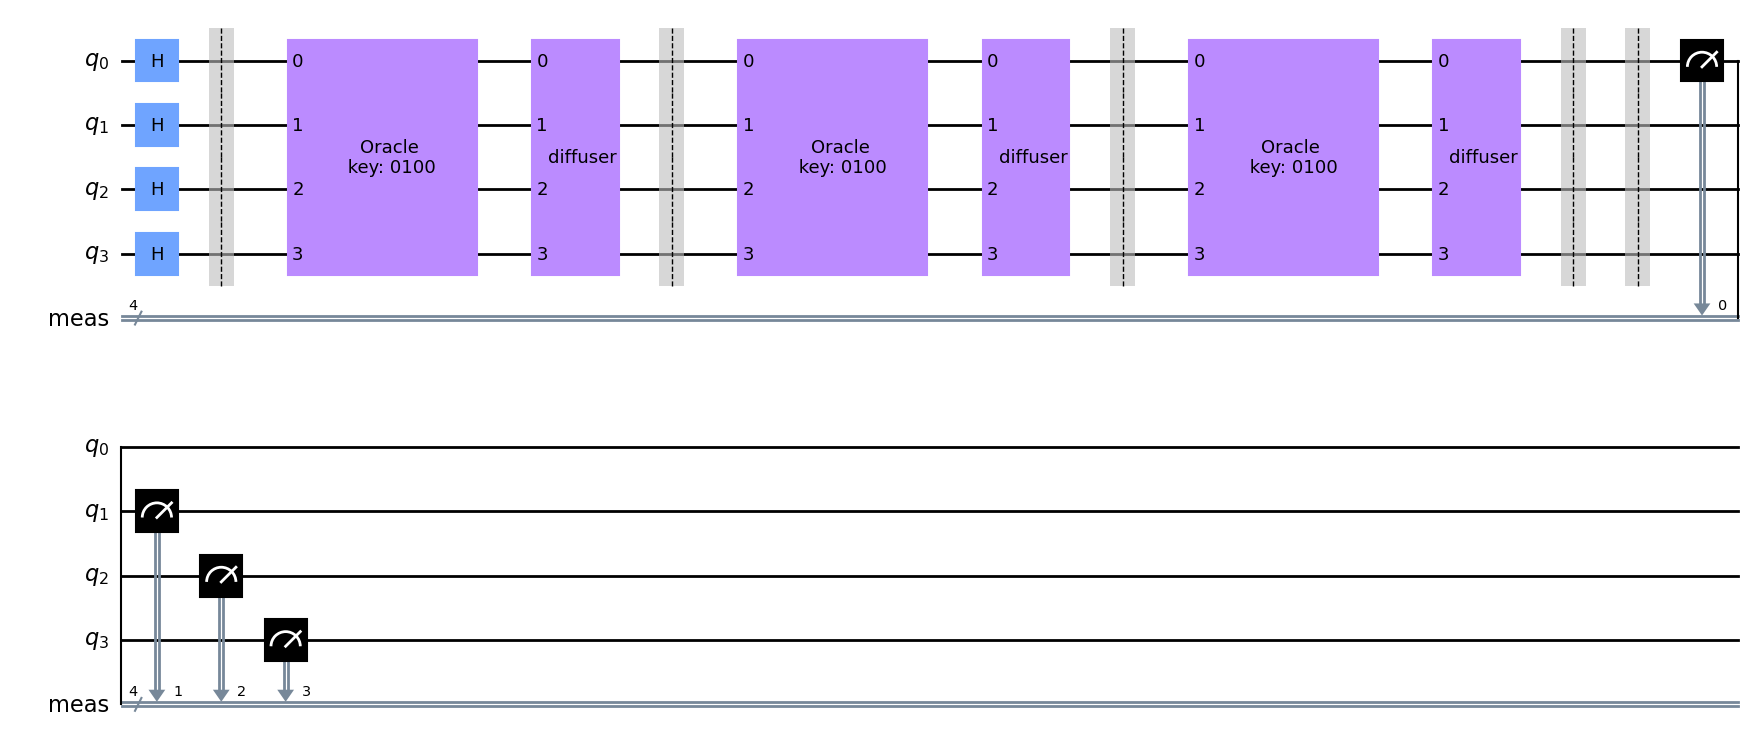

In [40]:
# Test environemnt

test_circuit = grover_circuit(number_of_qubits, key_for_grover)

#draw the test circuit

test_circuit.draw('mpl')

noisless simulation time taken: 0.002222299575805664


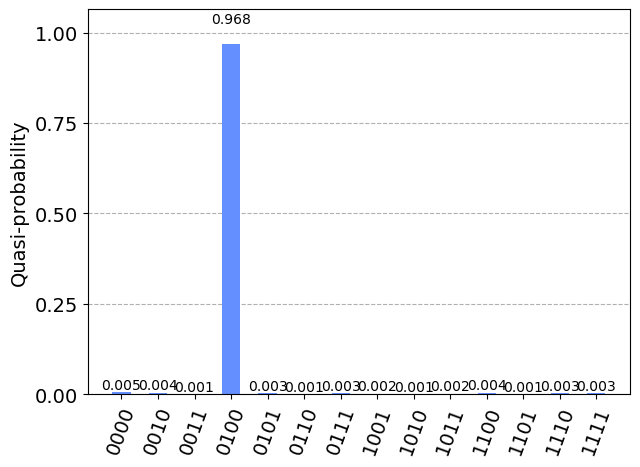

In [41]:
# noiseless simulation

#set backend
backend_sim = Aer.get_backend('qasm_simulator')
#transpile
job_sim = backend_sim.run(transpile(test_circuit, backend_sim), shots=1024)
#get result
result_sim = job_sim.result()
#get counts
counts = result_sim.get_counts(test_circuit)
#print execution time
print("noisless simulation time taken: "+ str(result_sim.time_taken))
total = sum(counts.values())
#convert count to probability
counts = {key: value / total for key, value in counts.items()}
#plot histogram
plot_histogram(counts)

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067148 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067183 > 1.066667). Truncating to maximum value.


noisy simulation time taken: 0.05388450622558594


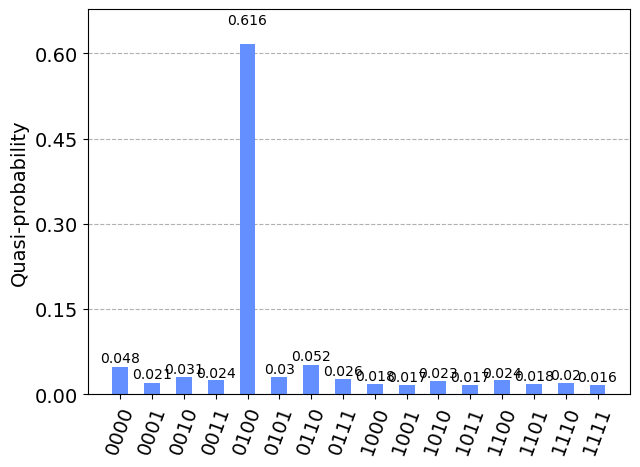

In [42]:
#noisy simulation
# set backend model with belem
noise_model = NoiseModel.from_backend(provider.get_backend('ibmq_belem'))
#define noise of basis gates
basis_gates = noise_model.basis_gates
#execute on backend
result = execute(test_circuit, Aer.get_backend('qasm_simulator'),
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()

#get counts
counts = result.get_counts(0)
total = sum(counts.values())
#convert count to probability
counts = {key: value / total for key, value in counts.items()}
#print execution time
print("noisy simulation time taken: "+ str(result.time_taken))
#plot histogram
plot_histogram(counts)

noisy simulation time taken: 0.035100460052490234


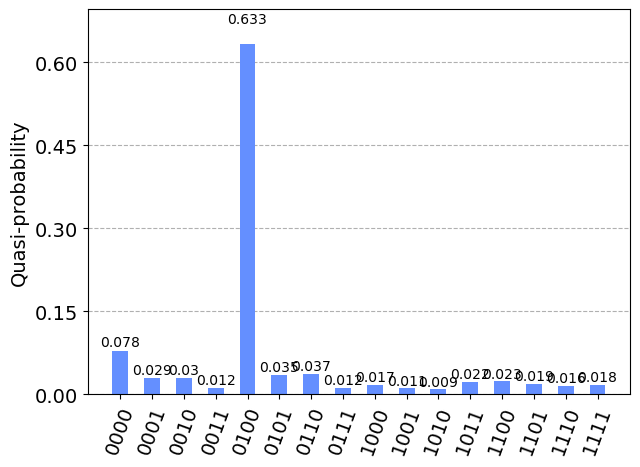

In [43]:
#noisy simulation
# set backend model with manila
noise_model = NoiseModel.from_backend(provider.get_backend('ibmq_manila'))
#define noise of basis gates
basis_gates = noise_model.basis_gates
#execute on backend
result = execute(test_circuit, Aer.get_backend('qasm_simulator'),
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()

#get counts
counts = result.get_counts(0)
total = sum(counts.values())
#convert count to probability
counts = {key: value / total for key, value in counts.items()}
#print execution time
print("noisy simulation time taken: "+ str(result.time_taken))
#plot histogram
plot_histogram(counts)